## Run RouskinHF across folders

In [13]:
import os
from rouskinhf import convert

path = '/Users/yvesmartin/data/RNAStralign'
for family in os.listdir(path):
    if not os.path.isdir(path+'/{}'.format(family)):
        continue
    for f in os.listdir(path+'/{}'.format(family)):
        if os.path.isdir(path+'/{}/{}'.format(family, f)):    
            data = convert(
                'ct',
                path+'/{}/{}'.format(family, f),
                name='{}-{}'.format(family, f),
                path_out='data',
                filter=True
            )
    if os.path.isfile('data/{}/{}'.format(family, f)):
        data = convert(
                'ct',
                path+'/{}'.format(family),
                name='{}'.format(family),
                path_out='data',
                filter=True
            )

Parsing ct files: 100%|██████████| 4206/4206 [00:06<00:00, 617.76it/s]


Over a total of 4206 datapoints, there are:
### OUTPUT
- ALL: 3159 valid datapoints
- INCLUDED: 6 duplicate sequences with different structure / dms / shape
### MODIFIED
- 0 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 858 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 189 duplicate sequences with the same structure / dms / shape


Parsing ct files: 100%|██████████| 4704/4704 [00:05<00:00, 808.64it/s]


Over a total of 4704 datapoints, there are:
### OUTPUT
- ALL: 3618 valid datapoints
- INCLUDED: 7 duplicate sequences with different structure / dms / shape
### MODIFIED
- 0 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 691 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 395 duplicate sequences with the same structure / dms / shape


Parsing ct files: 100%|██████████| 2946/2946 [00:04<00:00, 679.41it/s]


Over a total of 2946 datapoints, there are:
### OUTPUT
- ALL: 2166 valid datapoints
- INCLUDED: 4 duplicate sequences with different structure / dms / shape
### MODIFIED
- 0 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 459 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 321 duplicate sequences with the same structure / dms / shape


Parsing ct files: 0it [00:00, ?it/s]


Over a total of 0 datapoints, there are:
### OUTPUT
- ALL: 0 valid datapoints
- INCLUDED: 0 duplicate sequences with different structure / dms / shape
### MODIFIED
- 0 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 0 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures


Parsing ct files: 100%|██████████| 143/143 [00:00<00:00, 945.49it/s]


Over a total of 143 datapoints, there are:
### OUTPUT
- ALL: 10 valid datapoints
- INCLUDED: 4 duplicate sequences with different structure / dms / shape
### MODIFIED
- 5 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 133 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 0 duplicate sequences with the same structure / dms / shape


Parsing ct files: 100%|██████████| 81/81 [00:00<00:00, 2704.24it/s]


Over a total of 81 datapoints, there are:
### OUTPUT
- ALL: 4 valid datapoints
- INCLUDED: 2 duplicate sequences with different structure / dms / shape
### MODIFIED
- 3 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 77 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 0 duplicate sequences with the same structure / dms / shape


Parsing ct files: 100%|██████████| 54/54 [00:00<00:00, 2481.62it/s]


Over a total of 54 datapoints, there are:
### OUTPUT
- ALL: 0 valid datapoints
- INCLUDED: 0 duplicate sequences with different structure / dms / shape
### MODIFIED
- 0 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 54 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures


Parsing ct files: 100%|██████████| 68/68 [00:00<00:00, 2460.47it/s]


Over a total of 68 datapoints, there are:
### OUTPUT
- ALL: 49 valid datapoints
- INCLUDED: 24 duplicate sequences with different structure / dms / shape
### MODIFIED
- 26 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 19 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 0 duplicate sequences with the same structure / dms / shape


Parsing ct files: 100%|██████████| 349/349 [00:00<00:00, 3385.88it/s]


Over a total of 349 datapoints, there are:
### OUTPUT
- ALL: 53 valid datapoints
- INCLUDED: 4 duplicate sequences with different structure / dms / shape
### MODIFIED
- 11 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 284 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 12 duplicate sequences with the same structure / dms / shape


Parsing ct files: 100%|██████████| 29/29 [00:00<00:00, 2949.29it/s]


Over a total of 29 datapoints, there are:
### OUTPUT
- ALL: 2 valid datapoints
- INCLUDED: 1 duplicate sequences with different structure / dms / shape
### MODIFIED
- 1 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 27 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 0 duplicate sequences with the same structure / dms / shape


Parsing ct files: 100%|██████████| 163/163 [00:00<00:00, 2693.06it/s]


Over a total of 163 datapoints, there are:
### OUTPUT
- ALL: 6 valid datapoints
- INCLUDED: 2 duplicate sequences with different structure / dms / shape
### MODIFIED
- 2 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 157 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 0 duplicate sequences with the same structure / dms / shape


Parsing ct files: 100%|██████████| 13/13 [00:00<00:00, 2859.10it/s]


Over a total of 13 datapoints, there are:
### OUTPUT
- ALL: 0 valid datapoints
- INCLUDED: 0 duplicate sequences with different structure / dms / shape
### MODIFIED
- 0 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 13 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures


Parsing ct files: 100%|██████████| 34/34 [00:00<00:00, 3590.29it/s]


Over a total of 34 datapoints, there are:
### OUTPUT
- ALL: 7 valid datapoints
- INCLUDED: 3 duplicate sequences with different structure / dms / shape
### MODIFIED
- 5 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 27 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 0 duplicate sequences with the same structure / dms / shape


Parsing ct files: 100%|██████████| 96/96 [00:00<00:00, 2857.22it/s]


Over a total of 96 datapoints, there are:
### OUTPUT
- ALL: 3 valid datapoints
- INCLUDED: 1 duplicate sequences with different structure / dms / shape
### MODIFIED
- 1 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 93 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 0 duplicate sequences with the same structure / dms / shape


Parsing ct files: 0it [00:00, ?it/s]


Over a total of 0 datapoints, there are:
### OUTPUT
- ALL: 0 valid datapoints
- INCLUDED: 0 duplicate sequences with different structure / dms / shape
### MODIFIED
- 0 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 0 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures


Parsing ct files: 100%|██████████| 29/29 [00:00<00:00, 3170.13it/s]


Over a total of 29 datapoints, there are:
### OUTPUT
- ALL: 0 valid datapoints
- INCLUDED: 0 duplicate sequences with different structure / dms / shape
### MODIFIED
- 0 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 29 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures


Parsing ct files: 100%|██████████| 100/100 [00:00<00:00, 2096.71it/s]


Over a total of 100 datapoints, there are:
### OUTPUT
- ALL: 33 valid datapoints
- INCLUDED: 16 duplicate sequences with different structure / dms / shape
### MODIFIED
- 25 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 53 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 14 duplicate sequences with the same structure / dms / shape


Parsing ct files: 100%|██████████| 813/813 [00:00<00:00, 1920.91it/s]


Over a total of 813 datapoints, there are:
### OUTPUT
- ALL: 453 valid datapoints
- INCLUDED: 12 duplicate sequences with different structure / dms / shape
### MODIFIED
- 280 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 285 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 75 duplicate sequences with the same structure / dms / shape


Parsing ct files: 100%|██████████| 110/110 [00:00<00:00, 2448.15it/s]


Over a total of 110 datapoints, there are:
### OUTPUT
- ALL: 87 valid datapoints
- INCLUDED: 0 duplicate sequences with different structure / dms / shape
### MODIFIED
- 33 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 10 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 13 duplicate sequences with the same structure / dms / shape


Parsing ct files: 100%|██████████| 53/53 [00:00<00:00, 2487.20it/s]

Over a total of 53 datapoints, there are:
### OUTPUT
- ALL: 42 valid datapoints
- INCLUDED: 0 duplicate sequences with different structure / dms / shape
### MODIFIED
- 7 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 11 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 0 duplicate sequences with the same structure / dms / shape


In [17]:
data = {}
refs = {}
import json
for family in os.listdir('data'):
    path = 'data/{}/data.json'.format(family)
    if not os.path.isfile(path):
        continue
    temp = json.load(open(path))
    for k in temp:
        if k not in refs:
            refs[k] = 0
            data[k] = temp[k]
        else:
            refs[k] += 1
            data[f"{k}_{refs[k]}"] = temp[k]
            
json.dump(data, open('data.json', 'w'))

data = convert(
                'json',
                'data.json',
                name='RNAstralign',
                path_out='data',
                filter=True
            )

Parsing json file: 100%|██████████| 19746/19746 [00:00<00:00, 47317.13it/s]


Over a total of 19746 datapoints, there are:
### OUTPUT
- ALL: 19737 valid datapoints
- INCLUDED: 50 duplicate sequences with different structure / dms / shape
### MODIFIED
- 0 multiple sequences with the same reference (renamed reference)
### FILTERED OUT
- 0 invalid datapoints (ex: sequence with non-regular characters)
- 0 datapoints with bad structures
- 9 duplicate sequences with the same structure / dms / shape


## Visualise



<Axes: >

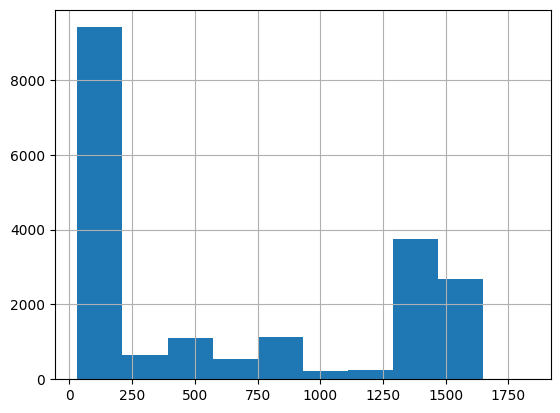

In [19]:
import pandas as pd

df = pd.read_json('data/RNAstralign/data.json', orient='index')
df.sequence.apply(len).hist(bins=10)

## Upload

In [20]:
from rouskinhf import upload_dataset
import envbash
envbash.load.load_envbash('../.env')

upload_dataset(
    'data/RNAstralign/data.json',
    commit_message='init commit'
)

data.json:   0%|          | 0.00/60.3M [00:00<?, ?B/s]